
# Tutorial 5: Transformers and Multi-Head Attention

* **Author:** Phillip Lippe
* **License:** CC BY-SA
* **Generated:** 2023-03-24T16:02:55.114581

In this tutorial, we will discuss one of the most impactful architectures of the last 2 years: the Transformer model.
Since the paper Attention Is All You Need by Vaswani et al. had been published in 2017,
the Transformer architecture has continued to beat benchmarks in many domains, most importantly in Natural Language Processing.
Transformers with an incredible amount of parameters can generate long, convincing essays, and opened up new application fields of AI.
As the hype of the Transformer architecture seems not to come to an end in the next years,
it is important to understand how it works, and have implemented it yourself, which we will do in this notebook.
This notebook is part of a lecture series on Deep Learning at the University of Amsterdam.
The full list of tutorials can be found at https://uvadlc-notebooks.rtfd.io.


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb)

Give us a ⭐ [on Github](https://www.github.com/Lightning-AI/lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install --quiet "torchmetrics>=0.7, <0.12" "pytorch-lightning>=1.4, <2.0.0" "ipython[notebook]>=8.0.0, <8.12.0" "setuptools==67.4.0" "lightning>=2.0.0rc0" "torchvision" "matplotlib" "torch>=1.8.1, <1.14.0" "seaborn" "matplotlib>=3.0.0, <3.4.0"

In [3]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Torchvision
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100
from tqdm.notebook import tqdm



from positional_encodings.torch_encodings import PositionalEncoding2D
import time
import pickle



plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Transformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

Two pre-trained models are downloaded below.
Make sure to have adjusted your `CHECKPOINT_PATH` before running this code if not already done.

In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file manually,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

In [305]:
from collections.abc import Sequence
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads): #, norm_type=None):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
       
        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()


    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        
        d_k = q.size()[-1]
        attention = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
        
        # import pdb; pdb.set_trace()
        att = attention.softmax(dim=-1)


        values = torch.matmul(att, v)

        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [419]:
pos_dim = 10

p_enc_2d = PositionalEncoding2D(pos_dim)
pos_embeddings = {}
# for i in range(1,200):
#     for j in range(2,100):    
z = torch.zeros(1,100,100,pos_dim)
# pos_embeddings[(i,j)] = p_enc_2d(z[:,:i,:j,:].to(DEVICE))
pos_embeddings = p_enc_2d(z.to(device))
    

In [420]:
from collections.abc import Sequence
class MultiheadAttention_KV(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads): #, norm_type=None):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
       
        self.kv_proj = nn.Linear(input_dim, 2 * embed_dim)
        
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        if attn_type == 'kv+pos':
            self.map_pos = nn.Linear(pos_dim, 1, bias=True)          
        
        self._reset_parameters()


    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.kv_proj.weight)
        self.kv_proj.bias.data.fill_(0)

        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

        if attn_type == 'kv+pos':
            nn.init.xavier_uniform_(self.map_pos.weight)
            self.map_pos.bias.data.fill_(0)
        

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        kv = self.kv_proj(x)

        # Separate Q, K, V from linear output
        kv = kv.reshape(batch_size, seq_length, self.num_heads, 2 * self.head_dim)
        kv = kv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        k, v = kv.chunk(2, dim=-1)

        # d_k = k.size()[-1]
        attention = torch.matmul(k, k.transpose(-2, -1))/math.sqrt(self.head_dim)
        
        if attn_type == 'kv+pos':
            pos = pos_embeddings[:,:seq_length,:seq_length,:] # 1, m, m, ? 
            attention = attention.unsqueeze(-1) + pos.unsqueeze(0)
            attention = self.map_pos(attention).squeeze(-1)
        
        att = attention.softmax(dim=-1)


        values = torch.matmul(att, v)

        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [421]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0): #, norm_type=None):
        """EncoderBlock.

        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads) if attn_type == 'qkv' else  MultiheadAttention_KV(input_dim, input_dim, num_heads)
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim),
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x


In [422]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

In [423]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """Positional Encoding.

        Args:
            d_model: Hidden dimensionality of the input.
            max_len: Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

In [424]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [408]:
class TransformerPredictor(L.LightningModule):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        lr,
        warmup,
        max_iters,
        dropout=0.0,
        input_dropout=0.0,
        # norm_type=None,
    ):
        """TransformerPredictor.

        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout), nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(
            num_layers=self.hparams.num_layers,
            input_dim=self.hparams.model_dim,
            dim_feedforward=2 * self.hparams.model_dim,
            num_heads=self.hparams.num_heads,
            dropout=self.hparams.dropout,
            # norm_type=self.hparams.norm_type
        )
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        x = self.positional_encoding(x)
        
        # plt.imshow(attention[0,0].cpu().numpy()); plt.show()
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        self.lr_scheduler = CosineWarmupScheduler(
            optimizer, warmup=self.hparams.warmup, max_iters=self.hparams.max_iters
        )
        return optimizer

    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.lr_scheduler.step()  # Step per iteration

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [484]:
# task type  'reverse','sort', 'swap'
which_task = 'copy' # 

In [485]:
class MyDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        
        if which_task == 'reverse':
            labels = torch.flip(inp_data, dims=(0,))
        elif which_task == 'sort':
            labels, _ = torch.sort(inp_data)
        elif which_task == 'sub':
            labels = 9 - inp_data
        else: #swap
            labels = torch.concat((inp_data[self.seq_len//2:], inp_data[:self.seq_len//2]), dim=0)
            
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`.
The label is simply the tensor flipped over the sequence dimension.
We can create the corresponding data loaders below.

In [486]:
sequence_length = 16

dataset = partial(MyDataset, 10, sequence_length)

train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(dataset(1000), batch_size=128)
test_loader = data.DataLoader(dataset(10000), batch_size=128)

Let's look at an arbitrary sample of the dataset:

In [487]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)
inp_data.shape

Input data: tensor([9, 2, 9, 5, 1, 4, 9, 7, 2, 0, 3, 5, 7, 5, 9, 6])
Labels:     tensor([2, 0, 3, 5, 7, 5, 9, 6, 9, 2, 9, 5, 1, 4, 9, 7])


torch.Size([16])

In [488]:
class MyPredictor(TransformerPredictor):
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        
        
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        
        if mode=="train":
            results[(attn_type, run_no)]['train_loss_history'].append(loss.item())
            results[(attn_type, run_no)]['time_spent'].append(time.time() - start_time)

        elif mode=="val":
            results[(attn_type, run_no)]['val_loss_history'].append(loss.item())       
            results[(attn_type, run_no)]['val_time_spent'].append(time.time() - start_time)   
        
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="val")
        
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")


In [489]:
def train_task(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "MYTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=1,
        max_epochs=num_epochs, # was 10 be default
        gradient_clip_val= 5,       
        val_check_interval=0.25,
        # val_check_interval=20
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    # pretrained_filename = os.path.join(CHECKPOINT_PATH, "MyTask.ckpt")
    # if os.path.isfile(pretrained_filename):
    #     print("Found pretrained model, loading...")
    #     model = MyPredictor.load_from_checkpoint(pretrained_filename)
    # else:
    model = MyPredictor(max_iters=trainer.max_epochs * len(train_loader), **kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)

    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "test_loss":test_result[0]['test_loss']}

    model = model.to(device)
    return model, result

In [490]:
# del reverse_model
# CHECKPOINT_PATH

# !pip install thop
# from thop import profile

# !pip install positional-encodings


In [496]:
num_epochs = 5

d_dim = 32
d_depth = 1

h_heads = 1

lr = 5e-3


num_runs = 1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 8.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


copy---------- norm type: qkv, run number: 0 ------------------------------


Sanity Checking: 0it [00:00, ?it/s]

/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

10346
tensor([1, 9, 2, 7, 2, 9, 0, 5, 0, 5, 7, 2, 3, 2, 0, 2], device='cuda:0')
tensor([0, 5, 7, 2, 3, 2, 0, 2, 1, 9, 2, 7, 2, 9, 0, 5], device='cuda:0')


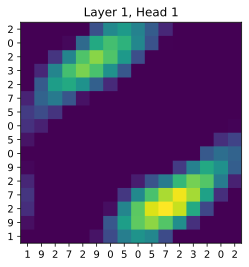

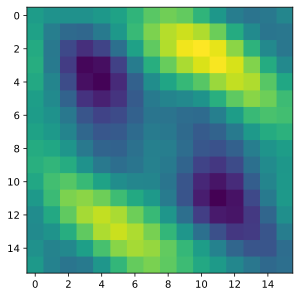

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 7.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)


copy---------- norm type: kv, run number: 0 ------------------------------


Sanity Checking: 0it [00:00, ?it/s]

/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

9290
tensor([1, 9, 2, 7, 2, 9, 0, 5, 0, 5, 7, 2, 3, 2, 0, 2], device='cuda:0')
tensor([0, 5, 7, 2, 3, 2, 0, 2, 1, 9, 2, 7, 2, 9, 0, 5], device='cuda:0')


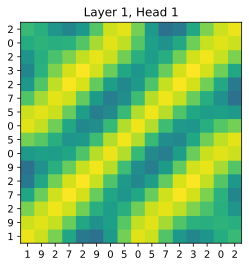

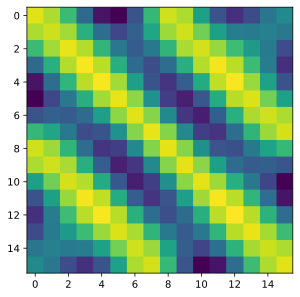

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 352   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 7.5 K 
3 | output_net          | Sequential         | 1.4 K 
-----------------------------------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)


copy---------- norm type: kv+pos, run number: 0 ------------------------------


Sanity Checking: 0it [00:00, ?it/s]

/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ali/miniconda3/envs/py39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

9301
tensor([1, 9, 2, 7, 2, 9, 0, 5, 0, 5, 7, 2, 3, 2, 0, 2], device='cuda:0')
tensor([0, 5, 7, 2, 3, 2, 0, 2, 1, 9, 2, 7, 2, 9, 0, 5], device='cuda:0')


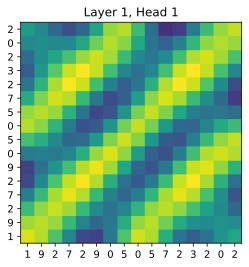

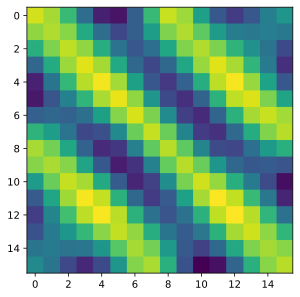

In [497]:
results = {}

data_input, labels = next(iter(test_loader))
inp_data = F.one_hot(data_input, num_classes=model.hparams.num_classes).float()
inp_data = inp_data.to(device)



# for norm_type in ['no-sm-std', 'no-sm-layernorm']:
for attn_type in ['qkv', 'kv', 'kv+pos']:

  for run_no in range(num_runs):
  
      print(f'{which_task}---------- norm type: {attn_type}, run number: {run_no} ------------------------------')


      results[(attn_type, run_no)] = {}
      results[(attn_type, run_no)]['time_spent'] = []  
      results[(attn_type, run_no)]['train_loss_history'] = []  
      results[(attn_type, run_no)]['val_loss_history'] = []  
      results[(attn_type, run_no)]['val_time_spent'] = []  

      start_time = time.time()

      model, my_result = train_task(
          input_dim=train_loader.dataset.num_categories,
          model_dim=d_dim,
          num_heads=h_heads,
          num_classes=train_loader.dataset.num_categories,
          num_layers=d_depth,
          dropout=0.1,
          lr=lr,
          warmup=5,       
          # norm_type= norm_type,
      )

      print(count_parameters(model))
        
      results[(attn_type, run_no)]['val_acc'] = my_result["val_acc"]
      results[(attn_type, run_no)]['test_acc'] = my_result["test_acc"]      



#       if not os.path.exists(f'./results'):
#         os.mkdir(f'./results')


#       with open(f'./results_new/synthetic/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}.pkl', 'wb') as f:
#         pickle.dump(results, f)





      # attention_maps[0].shape
      preds = model.forward(inp_data)
      print(inp_data[0].argmax(dim=-1))
      print(preds[0].argmax(dim=-1))
      attention_maps = model.get_attention_maps(inp_data)
      plot_attention_maps(data_input, attention_maps, idx=0)
      plt.imshow(attention_maps[0][0,0].cpu().numpy()); plt.show()



# # reverse_model
# input = torch.randn(1,16,10).to(device)
# macs, params = profile(reverse_model, inputs=(input, ))
# print(macs/1e6, params/1e6)

# plt.imshow(attention[0,0].cpu().numpy()); plt.show()
# plt.imshow(attention[0,0].detach().cpu().numpy()); plt.show()

In [493]:
plt.imshow(attention[0,0].cpu().numpy()); plt.show()

NameError: name 'attention' is not defined

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(count_parameters(model))

In [ ]:
a = torch.randint(1,10,(100,1))
b = torch.randint(1,10,(1,100))

In [ ]:
plt.imshow(a+b); plt.show()



In [ ]:
plt.imshow(attention[0,0].detach().cpu().numpy()); plt.show()
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [ ]:
# rm saved_models/Transformers/ReverseTask/ -rf

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [ ]:
# compute the averages 
results_avg = {}

for key, _ in results.keys():
    results_avg[key] = {}

for key in results.keys():
       for x,y in results[key].items():
          # import pdb; pdb.set_trace()
          if x in results_avg[key[0]]:
            results_avg[key[0]][x] += np.array(y)
          else: 
            results_avg[key[0]][x] = np.array(y)
    

# compute the avg
for key,val in results_avg.items():
      for x, y in val.items():
          y = np.array(y)
          results_avg[key][x] = y / num_runs


In [ ]:
smooth_factor_train = 10
smooth_factor_val = 10



fig, axs = plt.subplots(1,2) #, sharex=True, sharey=True)

colors = ['g-.', 'b:', 'k', 'r--', 'g:']

idx = 0
for key in results_avg.keys():
      t_time = results_avg[key]['time_spent'] 
      box_size = smooth_factor_train 
      tt = results_avg[key]['train_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[0].plot(t_time[box_size:-box_size], ss, colors[idx], lw=2)
      axs[0].grid('on')

      axs[0].set(title='train', xlabel='Training time (sec)', ylabel='Loss')


      idx += 1



idx = 0
for key in results_avg.keys():
      t_time = results_avg[key]['val_time_spent'] 
      box_size = smooth_factor_val 
      tt = results_avg[key]['val_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[1].plot(t_time[box_size:-box_size], ss, colors[idx], lw=2)
      axs[1].grid('on')

      axs[1].set(title='val', xlabel='Training time (sec)')

      axs[1].legend(list(results_avg.keys())) 

      idx += 1




fig.savefig(f'./results/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_avg.png', dpi=150, format="png")


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,7)) #, sharex=True, sharey=True)

idx = 0
for key, c in results.keys():
      t_time = results[(key, c)]['time_spent'] 
      box_size = smooth_factor_train 
      tt = results[(key, c)]['train_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]

      axs[0].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
      axs[0].grid('on')

      axs[0].set(title='train', xlabel='Training time (sec)', ylabel='Loss')

      idx += 1



idx = 0
for key, c in results.keys():
      t_time = results[(key, c)]['val_time_spent'] 
      box_size = smooth_factor_val 
      tt = results[(key, c)]['val_loss_history']
      ss = smooth(tt,box_size)[box_size:-box_size]      

      axs[1].plot(t_time[box_size:-box_size], ss, colors[idx//num_runs], lw=3)
      axs[1].grid('on')

      axs[1].set(title='val', xlabel='Training time (sec)')
      axs[1].legend(list(results.keys())) 

      idx += 1


fig.tight_layout()
plt.show()


# fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_all.png', dpi=150, format="png")

In [ ]:
fig = plt.figure(figsize=(2,3))

accs = []
for (key,val), c in zip(results_avg.items(), colors):
    accs.append(results_avg[key]['test_acc']*100)

bars = plt.bar(np.arange(len(accs)), accs)
plt.xticks(np.arange(len(accs)), list(results_avg.keys()), rotation=90)

# for bar,c in zip(bars, colors):
#   bar.set_color(c)

fig.gca().yaxis.grid(True, zorder=0,)
plt.ylabel('Acc (%)')
plt.ylim(0,100)
plt.show()



# fig.savefig(f'drive/MyDrive/KV_Transformer_Res/{d_dim}_{d_depth}_{h_heads}_{num_epochs}_{lr}_{sequence_length}_{which_task}_acc.png', dpi=150, format="png")

In [ ]:
# data_input, labels = next(iter(val_loader))
# inp_data = F.one_hot(data_input, num_classes=model.hparams.num_classes).float()

# inp_data = inp_data.to(device)

# # attention_maps[0].shape
# preds = model.forward(inp_data)

# print(inp_data[0].argmax(dim=-1))
# print(preds[0].argmax(dim=-1))



# attention_maps = model.get_attention_maps(inp_data)
# plot_attention_maps(data_input, attention_maps, idx=0)

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pickle 
# if not os.path.exists(f'drive/MyDrive/KV_Transformer_Res'):
#   os.mkdir(f'drive/MyDrive/KV_Transformer_Res')



# # with open(f'drive/MyDrive/KV_Transformer_Res/reverse_{model_dim}_{num_heads}_{num_layers}_{seq_len}.pkl', 'wb') as f:
# with open(f'drive/MyDrive/KV_Transformer_Res/reverse_{64}_{1}_{1}_{64}.pkl', 'wb') as f:
#   pickle.dump(results, f)

In [ ]:
reverse_result

In [ ]:
ls drive

The warning of PyTorch Lightning regarding the number of workers can be ignored for now.
As the data set is so simple and the `__getitem__` finishes a neglectable time, we don't need subprocesses
to provide us the data (in fact, more workers can slow down the training as we have communication overhead among processes/threads).
First, let's print the results:

In [ ]:
print("Val accuracy:  %4.2f%%" % (100.0 * reverse_result["val_acc"]))
print("Test accuracy: %4.2f%%" % (100.0 * reverse_result["test_acc"]))

As we would have expected, the Transformer can correctly solve the task.
However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input?
Let's try to visualize it below.

In [ ]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=model.hparams.num_classes).float()



In [ ]:
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data)

In [ ]:
inp_data[0].argmax(dim=-1)

The object `attention_maps` is a list of length $N$ where $N$ is the number of layers.
Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [ ]:
# attention_maps[0].shape
preds = model.forward(inp_data)
preds[0].argmax(dim=-1)

In [ ]:
output[0].shape

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index
indicating for which batch element we want to visualize the attention map.
We will create a plot where over rows, we have different layers, while over columns, we show the different heads.
Remember that the softmax has been applied for each row separately.

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()


Finally, we can plot the attention map of our trained Transformer on the reverse task:

In [ ]:
%matplotlib inline
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself.
Hence, it actually does what we intended it to do.
We see that it however also pays some attention to values close to the flipped index.
This is because the model doesn't need the perfect, hard attention to solve this problem,
but is fine with this approximate, noisy attention map.
The close-by indices are caused by the similarity of the positional encoding,
which we also intended with the positional encoding.

### Set Anomaly Detection

Besides sequences, sets are another data structure that is relevant for many applications.
In contrast to sequences, elements are unordered in a set.
RNNs can only be applied on sets by assuming an order in the data, which however biases the model towards
a non-existing order in the data.
[Vinyals et al.
(2015)](https://arxiv.org/abs/1511.06391) and other papers have shown that the assumed order can have a significant
impact on the model's performance, and hence, we should try to not use RNNs on sets.
Ideally, our model should be permutation-equivariant/invariant such that the output is the same no matter how we sort the elements in a set.

Transformers offer the perfect architecture for this as the Multi-Head Attention is permutation-equivariant, and thus,
outputs the same values no matter in what order we enter the inputs (inputs and outputs are permuted equally).
The task we are looking at for sets is _Set Anomaly Detection_ which means that we try to find the element(s)
in a set that does not fit the others.
In the research community, the common application of anomaly detection is performed on a set of images,
where $N-1$ images belong to the same category/have the same high-level features while one belongs to another category.
Note that category does not necessarily have to relate to a class in a standard classification problem,
but could be the combination of multiple features.
For instance, on a face dataset, this could be people with glasses, male, beard, etc.
An example of distinguishing different animals can be seen below.
The first four images show foxes, while the last represents a different animal.
We want to recognize that the last image shows a different animal, but it is not relevant which class of animal it is.

<center width="100%" style="padding:20px"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/cifar100_example_anomaly.png" width="600px"></center>

In this tutorial, we will use the CIFAR100 dataset.
CIFAR100 has 600 images for 100 classes each with a resolution of 32x32, similar to CIFAR10.
The larger amount of classes requires the model to attend to specific features in the images instead
of coarse features as in CIFAR10, therefore making the task harder.
We will show the model a set of 9 images of one class, and 1 image from another class.
The task is to find the image that is from a different class than the other images.
Using the raw images directly as input to the Transformer is not a good idea, because it is not translation
invariant as a CNN, and would need to learn to detect image features from high-dimensional input first of all.
Instead, we will use a pre-trained ResNet34 model from the torchvision package to obtain high-level,
low-dimensional features of the images.
The ResNet model has been pre-trained on the [ImageNet](http://image-net.org/) dataset which contains
1 million images of 1k classes and varying resolutions.
However, during training and testing, the images are usually scaled to a resolution of 224x224,
and hence we rescale our CIFAR images to this resolution as well.
Below, we will load the dataset, and prepare the data for being processed by the ResNet model.

In [ ]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1, 3, 1, 1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1, 3, 1, 1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)]
)
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

Next, we want to run the pre-trained ResNet model on the images, and extract the features before the classification layer.
These are the most high-level features, and should sufficiently describe the images.
CIFAR100 has some similarity to ImageNet, and thus we are not retraining the ResNet model in any form.
However, if you would want to get the best performance and have a very large dataset,
it would be better to add the ResNet to the computation graph during training and finetune its parameters as well.
As we don't have a large enough dataset and want to train our model efficiently, we will extract the features beforehand.
Let's load and prepare the model below.

In [ ]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

We will now write a extraction function for the features below.
This cell requires access to a GPU, as the model is rather deep and the images relatively large.
The GPUs on GoogleColab are sufficient, but running this cell can take 2-3 minutes.
Once it is run, the features are exported on disk so they don't have to be recalculated every time you run the notebook.
However, this requires >150MB free disk space.
So it is recommended to run this only on a local computer if you have enough free disk and a GPU (GoogleColab is fine for this).
If you do not have a GPU, you can download the features from the
[GoogleDrive folder](https://drive.google.com/drive/folders/1DF7POc6j03pRiWQPWSl5QJX5iY-xK0sV?usp=sharing).

In [ ]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features


train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

Let's verify the feature shapes below.
The training should have 50k elements, and the test 10k images.
The feature dimension is 512 for the ResNet34.
If you experiment with other models, you likely see a different feature dimension.

In [ ]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

As usual, we want to create a validation set to detect when we should stop training.
In this case, we will split the training set into 90% training, 10% validation.
However, the difficulty is here that we need to ensure that the validation set has the same number of images for all 100 labels.
Otherwise, we have a class imbalance which is not good for creating the image sets.
Hence, we take 10% of the images for each class, and move them into the validation set.
The code below does exactly this.

In [ ]:
# Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max() + 1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1)  # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices = sorted_indices[:, :num_val_exmps].reshape(-1)
train_indices = sorted_indices[:, num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats, val_labels = train_set_feats[val_indices], labels[val_indices]

Now we can prepare a dataset class for the set anomaly task.
We define an epoch to be the sequence in which each image has been exactly once as an "anomaly".
Hence, the length of the dataset is the number of images in it.
For the training set, each time we access an item with `__getitem__`, we sample a random,
different class than the image at the corresponding index `idx` has.
In a second step, we sample $N-1$ images of this sampled class.
The set of 10 images is finally returned.
The randomness in the `__getitem__` allows us to see a slightly different set during each iteration.
However, we can't use the same strategy for the test set as we want the test dataset to be the same every time we iterate over it.
Hence, we sample the sets in the `__init__` method, and return those in `__getitem__`.
The code below implements exactly this dynamic.

In [ ]:
class SetAnomalyDataset(data.Dataset):
    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Args:
            img_feats: Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels: Tensor of shape [num_imgs], containing the class labels for the images
            set_size: Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train: If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size - 1  # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max() + 1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()

    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets

    def sample_img_set(self, anomaly_label):
        """Samples a new set of images, given the label of the anomaly.

        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels - 1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices

    def __len__(self):
        return self.img_feats.shape[0]

    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train:  # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else:  # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0] - 1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

Next, we can setup our datasets and data loaders below.
Here, we will use a set size of 10, i.e. 9 images from one category + 1 anomaly.
Feel free to change it if you want to experiment with the sizes.

In [ ]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset = SetAnomalyDataset(val_feats, val_labels, set_size=SET_SIZE, train=False)
test_anom_dataset = SetAnomalyDataset(test_feats, test_labels, set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(
    train_anom_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4, pin_memory=True
)
val_anom_loader = data.DataLoader(val_anom_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader = data.DataLoader(test_anom_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

To understand the dataset a little better, we can plot below a few sets from the test dataset.
Each row shows a different input set, where the first 9 are from the same class.

In [ ]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12, 8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis("off")
    plt.show()
    plt.close()


_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

We can already see that for some sets the task might be easier than for others.
Difficulties can especially arise if the anomaly is in a different, but yet visually similar class
(e.g. train vs bus, flour vs worm, etc.
).

After having prepared the data, we can look closer at the model.
Here, we have a classification of the whole set.
For the prediction to be permutation-equivariant, we will output one logit for each image.
Over these logits, we apply a softmax and train the anomaly image to have the highest score/probability.
This is a bit different than a standard classification layer as the softmax is applied over images,
not over output classes in the classical sense.
However, if we swap two images in their position, we effectively swap their position in the output softmax.
Hence, the prediction is equivariant with respect to the input.
We implement this idea below in the subclass of the Transformer Lightning module.

In [ ]:
class AnomalyPredictor(TransformerPredictor):
    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        # No positional encodings as it is a set, not a sequence!
        preds = self.forward(img_sets, add_positional_encoding=False)
        preds = preds.squeeze(dim=-1)  # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels)  # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc, on_step=False, on_epoch=True)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Finally, we write our train function below.
It has the exact same structure as the reverse task one, hence not much of an explanation is needed here.

In [ ]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=1,
        max_epochs=100,
        gradient_clip_val=2,
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs * len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, dataloaders=train_anom_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=val_anom_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_anom_loader, verbose=False)
    result = {
        "test_acc": test_result[0]["test_acc"],
        "val_acc": val_result[0]["test_acc"],
        "train_acc": train_result[0]["test_acc"],
    }

    model = model.to(device)
    return model, result

Let's finally train our model.
We will use 4 layers with 4 attention heads each.
The hidden dimensionality of the model is 256, and we use a dropout of 0.1 throughout the model for good regularization.
Note that we also apply the dropout on the input features, as this makes the model more robust against
image noise and generalizes better.
Again, we use warmup to slowly start our model training.

In [ ]:
anomaly_model, anomaly_result = train_anomaly(
    input_dim=train_anom_dataset.img_feats.shape[-1],
    model_dim=256,
    num_heads=4,
    num_classes=1,
    num_layers=4,
    dropout=0.1,
    input_dropout=0.1,
    lr=5e-4,
    warmup=100,
    seq_length=10
)

We can print the achieved accuracy below.

In [ ]:
print("Train accuracy: %4.2f%%" % (100.0 * anomaly_result["train_acc"]))
print("Val accuracy:   %4.2f%%" % (100.0 * anomaly_result["val_acc"]))
print("Test accuracy:  %4.2f%%" % (100.0 * anomaly_result["test_acc"]))

With ~94% validation and test accuracy, the model generalizes quite well.
It should be noted that you might see slightly different scores depending on what computer/device you are running this notebook.
This is because despite setting the seed before generating the test dataset, it is not the same across platforms and numpy versions.
Nevertheless, we can conclude that the model performs quite well and can solve the task for most sets.
Before trying to interpret the model, let's verify that our model is permutation-equivariant,
and assigns the same predictions for different permutations of the input set.
For this, we sample a batch from the test set and run it through the model to obtain the probabilities.

In [ ]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:, permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

# assert (preds[:, permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0, permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

You can see that the predictions are almost exactly the same, and only differ because of slight numerical
differences inside the network operation.

To interpret the model a little more, we can plot the attention maps inside the model.
This will give us an idea of what information the model is sharing/communicating between images,
and what each head might represent.
First, we need to extract the attention maps for the test batch above, and determine the discrete predictions for simplicity.

In [ ]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

Below we write a plot function which plots the images in the input set, the prediction of the model,
and the attention maps of the different heads on layers of the transformer.
Feel free to explore the attention maps for different input examples as well.

In [ ]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx : idx + 1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)


visualize_prediction(0)

Depending on the random seed, you might see a slightly different input set.
For the version on the website, we compare 9 tree images with a volcano.
We see that multiple heads, for instance, Layer 2 Head 1, Layer 2 Head 3, and Layer 3 Head 1 focus on the last image.
Additionally, the heads in Layer 4 all seem to ignore the last image and assign a very low attention probability to it.
This shows that the model has indeed recognized that the image doesn't fit the setting, and hence predicted it to be the anomaly.
Layer 3 Head 2-4 seems to take a slightly weighted average of all images.
That might indicate that the model extracts the "average" information of all images, to compare it to the image features itself.

Let's try to find where the model actually makes a mistake.
We can do this by identifying the sets where the model predicts something else than 9, as in the dataset,
we ensured that the anomaly is always at the last position in the set.

In [ ]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

As our model achieves ~94% accuracy, we only have very little number of mistakes in a batch of 64 sets.
Still, let's visualize one of them, for example the last one:

In [ ]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print("Image %i: %4.2f%%" % (i, 100.0 * p))

In this example, the model confuses a palm tree with a building, giving a probability of ~90% to image 2, and 8% to the actual anomaly.
However, the difficulty here is that the picture of the building has been taken at a similar angle as the palms.
Meanwhile, image 2 shows a rather unusual palm with a different color palette, which is why the model fails here.
Nevertheless, in general, the model performs quite well.

## Conclusion

In this tutorial, we took a closer look at the Multi-Head Attention layer which uses a scaled dot product between
queries and keys to find correlations and similarities between input elements.
The Transformer architecture is based on the Multi-Head Attention layer and applies multiple of them in a ResNet-like block.
The Transformer is a very important, recent architecture that can be applied to many tasks and datasets.
Although it is best known for its success in NLP, there is so much more to it.
We have seen its application on sequence-to-sequence tasks and set anomaly detection.
Its property of being permutation-equivariant if we do not provide any positional encodings, allows it to generalize to many settings.
Hence, it is important to know the architecture, but also its possible issues such as the gradient problem during
the first iterations solved by learning rate warm-up.
If you are interested in continuing with the study of the Transformer architecture,
please have a look at the blog posts listed at the beginning of the tutorial notebook.

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/Lightning-AI/lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/Lightning-AI/lightning) or [Bolt](https://github.com/Lightning-AI/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/Lightning-AI/lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/Lightning-AI/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[Pytorch Lightning{height="60px" width="240px"}](https://pytorchlightning.ai)